<a href="https://www.kaggle.com/code/rubanzasilva/fast-ai-gradient-boosting?scriptVersionId=192963167" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library Imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mushroom_predicition_nn/pytorch/default/1/mushroom_prediction_model.pth
/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


In [3]:
%pip install catboost
%pip install optuna
%pip install optuna_distributed
%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
%pip install wandb
%pip install sweetviz


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: distributed
    Found existing installation: distributed 2024.5.1
    Uninstalling distributed-2024.5.1:
      Successfully uninstalled distributed-2024.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rapids-dask-dependency 24.6.0a0 requires dask==2024.5.1, but you have dask 2024.7.0 which is incompatible.
rapids-dask-dependency 24.6.0a0 requires distributed==2024.5.1, but you have distributed 2024.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

In [4]:
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,mean_squared_error, matthews_corrcoef
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score



#transformers and pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv





import optuna
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler
import warnings


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp



from openfe import OpenFE, transform
from autogluon.tabular import TabularDataset, TabularPredictor

import h2o
from h2o.automl import H2OAutoML

import gc

from xgboost import plot_importance
import wandb

import sweetviz as sv
#from IPython.display import FileLink

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
#wandb.login()

In [6]:
path = Path('/kaggle/input/playground-series-s4e8/')
path

Path('/kaggle/input/playground-series-s4e8')

In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')

# Exploratory Data Analysis

### Feature Description from the secondary mushroom [dataset](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset).

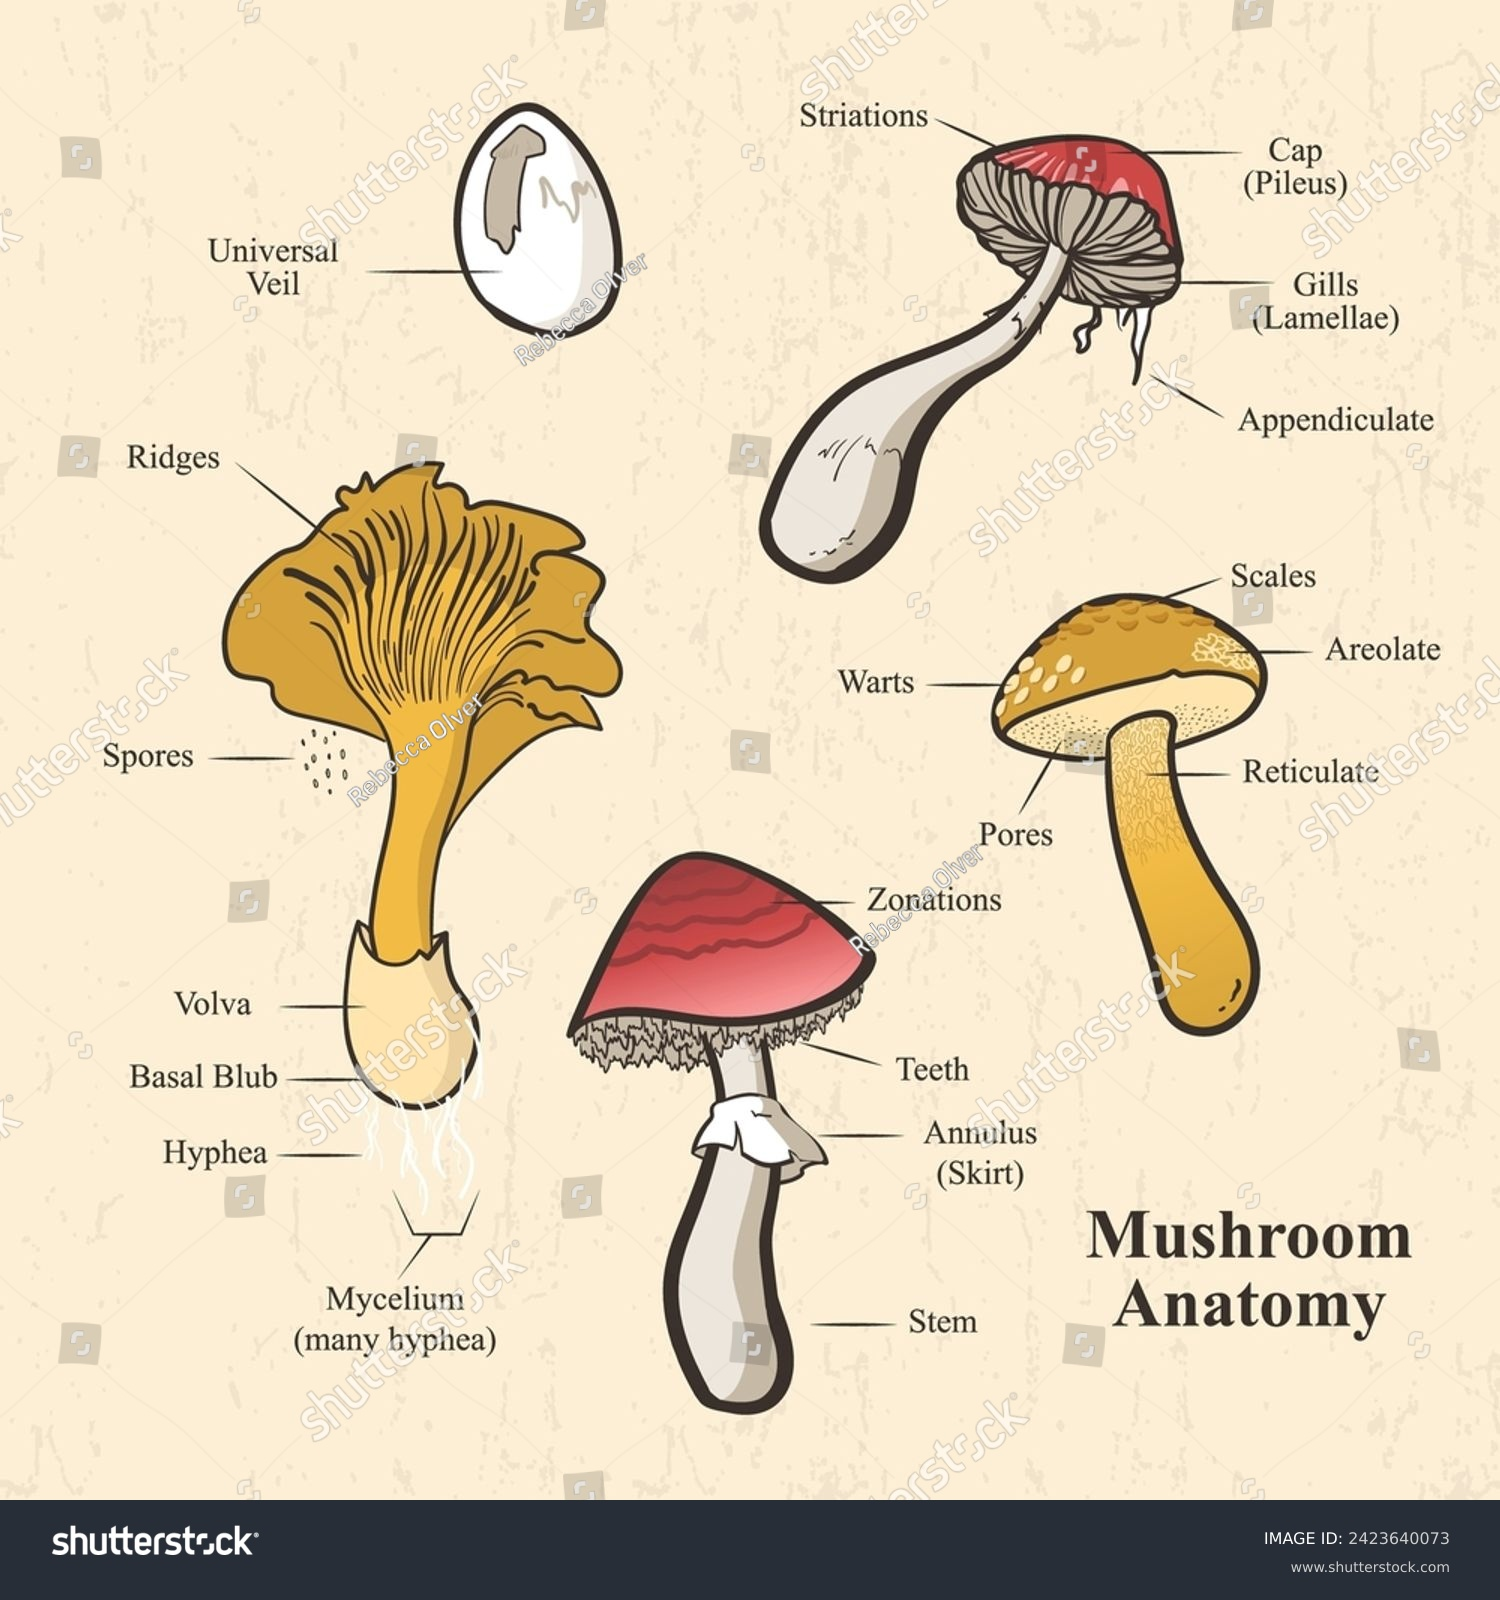

Based off various discussions listed below, i concluded that the secondary mushroom dataset was the true original dataset, so i have used feature descriptions based of that.
https://www.kaggle.com/competitions/playground-series-s4e8/discussion/527548


Per wikipedia,a mushroom is the fleshy, spore-bearing fruiting body of a fungus, typically produced above ground, on soil, or on its food source.

The secondary mushroom dataset follows the format of the primary mushroom dataset which was linked in the data description on Kaggle albeit having more mushroom species.

Class - One binary class divided in edible=e and poisonous=p (with the latter one also containing mushrooms of unknown edibility).

#### Mushroom cap - This is the cap like structure on the top of the mushroom also refered to as the Pileus that holds together the gills.It can take on various characteristics such as shape etc.

1. cap-diameter:- This represents the diameter of the mushroom's cap and is recorded in cm as a float.

2. cap-shape:- This represents the shape of a mushroom's cap which takes on various shapes i.e bell-shaped, triangular etc.
In this dataset the cap shape has been represented by bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p and others=o

3. cap-surface:- This represents the texture of the surface of a mushroom cap. 
In this dataset, we have the following classes fibrous=i, grooves=g, scaly=y, smooth=s,shiny=h, leathery=l, silky=k, sticky=t,wrinkled=w and fleshy=e.

4. cap-color:-This represents the color of a mushroom's cap.In this dataset, the colors were grouped into brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l,orange=o, black=k.

5. does-bruise-bleed:- Mushrooms can also be indentified based of whether the mushroom bruises/bleeds when cut.Here bruises-or-bleeding is represented by t while no bruising/bleeding is represented by f.

#### It is also important to take note of the characteristics under the mushroom cap as in some cases the upperside can look very similar and the underside can help identify the edible mushrooms more accurately.Under the cap, usually lies gills, pores,ridges,teeth etc.

#### Mushroom gills also known as lamellae, are the rib like features found under the cap of many species of mushroom.Gills have a number of differing physical features that can help us identify a mushroom such as spacing, color, shape, width etc. Gills are used for spore production dispersal.

6. gill-attachment:- The way gills are attached to the stem provide information about what type of mushroom it might be.Some gills might be attached to the stem with varying degrees while others arent atttached at all.See figure(B) for reference. In this dataset, the mushrooms are grouped into adnate=a, adnexed=x, decurrent=d, free=e,sinuate=s, pores=p, none=f and unknown=?

7. gill-spacing:Different mushrooms have varying degrees of spacing between the rib like structures we described above, the gills.The gills can be close, crowded, sub-distant and distant.In our dataset, this is represented as c for close, d for distant and f for none. 

8. gill-color:This feature represents the color of the gills which can help us classifiy our edible and poisonous mushrooms better.The color is represented as follows:- brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l,+ none=f

#### The stem of the mushroom which is the stalk-like structure that supports the cap whose features also provide us with valuable insights when classifying mushrooms.

9. stem-height:This is recorded as a float in centimeters.It represents the height of the stalk-like feature.

10. stem-width:This feature represents the width of the mushroom stem. It is a continous variable represented as a float in millimeters.

11. stem-root:The various mushrooms have different looking bases which can also help us identify the features.This is grouped as follows bulbous=b, swollen=s, club=c, cup=u, equal=e, rhizomorphs=z and rooted=r.

12. stem-surface:Here we describe the texture of the stem surface.The feature is grouped as follows fibrous=i, grooves=g, scaly=y, smooth=s,shiny=h, leathery=l, silky=k, sticky=t,wrinkled=w and fleshy=e. and none=f

13. stem-color:This describes the color of the stem and is grouped into brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l,orange=o, black=k and none=f.

#### A veil is a thin membrane that covers the cap and stem of a young mushroom. As the mushroom grows, it usually ruptures by force of the growing mushroom and in some cases, it tends to leave remnants of the veil such as a ring etc.This feature in combination with others helps identify the mushroom as edible or not with better precision.

14. veil-type:The veil can either fully cover the cap and stem of the young mushroom or partially.Here it covers just the spore producing parts of the mushroom such as the gill.In this dataset,we represent this as p for partial and u for universal.

15. veil-color:This represents the color of the veil described above. The color is represented as follows:- brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l,orange=o, black=k and none=f

16. has-ring:When the mushrooms breaks out of its veil, it usually leaves a ring also called an Annulus. In this dataset, this is represented as t if it has a ring and f if it doesnt.

17. ring-type:- The ring can take on various characteristics and types.For this dataset, they are represented as follows: cobwebby=c, evanescent=e, flaring=r, grooved=g,large=l, pendant=p, sheathing=s, zone=z, scaly=y, movable=m, none=f, unknown=?

#### Mushroom spores are used for reproduction and act as the "seed" of the mushroom.The color of spores varies between mushroom species and is a crucial feature for identifing the mushroom.

18. spore-print-color:This represents the color of the spores of a particular mushroom and in this dataset are grouped as follows:-brown=n, buff=b, gray=g, green=r, pink=p,purple=u, red=e, white=w, yellow=y, blue=l.

19. habitat:Here we describe the habitat where the mushroom is found represented by grasses=g, leaves=l, meadows=m, paths=p, heaths=h, urban=u, waste=w, woods=d

20. season:This represents the weather season at the time when the particular mushroom was found. It is represented as follows: spring=s, summer=u, autumn=a, winter=w

#### Remember as stated in the dataset description, we know that no one feature can be used to correctly classify the mushroom as edible or poisonous. Its is only by using a combination of the above features that we can hope to correctly classify a mushroom as edible or otherwise.

### Initial Exploration

#### SweetViz

In [8]:
#my_report = sv.analyze(train_df)
#my_report.show_html()

In [9]:
train_df.shape,test_df.shape

((3116945, 21), (2077964, 20))

In [10]:
train_df.columns

Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [11]:
train_df

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,,
0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3116940,e,9.29,f,NaN,n,t,NaN,NaN,w,12.14,18.81,b,NaN,w,u,w,t,g,NaN,d,u
3116941,e,10.88,s,NaN,w,t,d,c,p,6.65,26.97,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
3116942,p,7.82,x,e,e,f,a,NaN,w,9.51,11.06,NaN,NaN,y,NaN,w,t,z,NaN,d,a


#### Summary Statistics

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 523.2+ MB


As expected, there are only 3 columns with float which symbolizes the continous variables

In [13]:
train_df.describe(include=[object]).T

,count,unique,top,freq
class,3116945,2,p,1705396
cap-shape,3116905,74,x,1436026
cap-surface,2445922,83,t,460777
cap-color,3116933,78,n,1359542
does-bruise-or-bleed,3116937,26,f,2569743
gill-attachment,2593009,78,a,646034
gill-spacing,1858510,48,c,1331054
gill-color,3116888,63,w,931538
stem-root,359922,38,b,165801
stem-surface,1136084,60,s,327610


In [14]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
cap-diameter,3116941.0,6.309848,4.657931,0.03,3.32,5.75,8.24,80.67
stem-height,3116945.0,6.348333,2.699755,0.00,4.67,5.88,7.41,88.72
stem-width,3116945.0,11.153785,8.095477,0.00,4.97,9.65,15.63,102.90


By looking at the number of unique values in the categorical variable columns,we can already tell that their is a high cardinality among most of the categorical variables.Something i validate below.

This can be caused by data entry errors or mixing up of column data etc.

**Potential Solutions**

Group the less common variables into an "other" column.

Group related features using embeddings etc.

Remove incorrect values

Using fastai's FillMissing to handle NaN's.

#### Unique variable check

While doing **train_df.describe(include=[object]).T**, i noticed that some categorical values have way more unique values than expected, as almost all of the columns have a high number of category levels compared to the feature dictionary.

I shall start by checking out the categorical variables to see if the number of unique values in the column match the expected categories in the feature dictionary.

#### cap-shape

We expect this to be represented by bell=b, conical=c, convex=x, flat=f, sunken=s, spherical=p and others=o

In [17]:
train_df['cap-shape'].nunique()

74

In [18]:
train_df['cap-shape'].unique()

array(['f', 'x', 'p', 'b', 'o', 'c', 's', 'd', 'e', 'n', nan, 'w', 'k', 'l', '19.29', '5 f', 't', 'g', 'z', 'a', '2.85', '7 x',
       'r', 'u', '3.55', 'is s', 'y', '4.22', '3.6', '21.56', 'i', '6 x', '24.16', '8', 'm', 'ring-type', '10.13', 'is p',
       '7.43', 'h', '0.82', '10.46', '2.77', '2.94', '12.62', '5.15', '19.04', '4.97', '49.21', 'b f', '9.13', '1.66', '3.37',
       '7.21', '3.25', '11.12', '3 x', '4.3', '7.41', '6.21', '8.29', '54.78', '20.25', '3.52', '3.04', '2.63', '3.91', '6.44',
       '8.3', '7.6', '17.44', '4.33', '2.82', '6.53', '19.06'], dtype=object)

#### cap-color

In [19]:
train_df['cap-color'].nunique()

78

In [20]:
train_df['cap-shape'].unique()

array(['f', 'x', 'p', 'b', 'o', 'c', 's', 'd', 'e', 'n', nan, 'w', 'k', 'l', '19.29', '5 f', 't', 'g', 'z', 'a', '2.85', '7 x',
       'r', 'u', '3.55', 'is s', 'y', '4.22', '3.6', '21.56', 'i', '6 x', '24.16', '8', 'm', 'ring-type', '10.13', 'is p',
       '7.43', 'h', '0.82', '10.46', '2.77', '2.94', '12.62', '5.15', '19.04', '4.97', '49.21', 'b f', '9.13', '1.66', '3.37',
       '7.21', '3.25', '11.12', '3 x', '4.3', '7.41', '6.21', '8.29', '54.78', '20.25', '3.52', '3.04', '2.63', '3.91', '6.44',
       '8.3', '7.6', '17.44', '4.33', '2.82', '6.53', '19.06'], dtype=object)

#### Stem-surface

In [21]:
train_df['stem-surface'].head(100)

id
0     NaN
1       y
2       s
3     NaN
4     NaN
     ... 
95    NaN
96    NaN
97    NaN
98      h
99      y
Name: stem-surface, Length: 100, dtype: object

In [22]:
# Set the display option to show all rows
pd.set_option('display.max_rows', None)

# To get a random sample of 100 rows from the 'stem-surface' column
random_sample = train_df['stem-surface'].sample(n=100, random_state=42)
print(random_sample)

# Reset the display option to default (optional)
pd.reset_option('display.max_rows')

id
1356763      t
2369311      g
1146527    NaN
889383     NaN
416134     NaN
1602820    NaN
2155775    NaN
2530750      s
2700649    NaN
2094611    NaN
1194552    NaN
3109341    NaN
564687     NaN
2051592      t
2155505    NaN
1417455      y
2671503    NaN
381262     NaN
566034     NaN
1780618    NaN
2707666      s
1836459      t
2768391    NaN
1619370      s
1693998    NaN
1982706      s
1912528      i
2276478    NaN
2181069      i
2665354      y
670084     NaN
343920     NaN
1746578    NaN
2718699      i
293992     NaN
1140811    NaN
2622612      y
1166948    NaN
1358926    NaN
289560       s
2397359    NaN
157493     NaN
964219       s
579790     NaN
2737752    NaN
3072864    NaN
2220594    NaN
3066203    NaN
1802722      t
2276258    NaN
1990864    NaN
2054365      k
1304696      g
2247528      i
2665061      i
1621159    NaN
284047     NaN
873929     NaN
739628       i
1373585      k
1560818    NaN
2622909    NaN
1589841    NaN
1196767      h
1350544    NaN
2493024      s
1942264

In [23]:
unique_stem_surfaces = train_df['stem-surface'].unique()
print(unique_stem_surfaces)

[nan 'y' 's' 't' 'g' 'h' 'k' 'i' 'f' 'l' 'd' 'x' '12.04' 'w' 'a' 'o' 'c' 'n' 'm' 'e' 'p' 'z' '6.58' '4.34' 'b' '3.89' 'r' '25.83'
 '1.59' '0.0' '5.97' '5.81' 'u' 'season' '10.48' '3.68' '5.56' '4.41' '5.48' '5.51' 'class' 'has-ring' '13.1' '17.46' '5.35'
 '7.23' 'does None' '1.03' 'does s' '7.45' 'has h' 'does-bruise-or-bleed' '1.94' '49.46' '19.35' '2.68' '4.74'
 'spore-print-color' '10.93' '24.12' '13.94']


In [24]:
train_df['stem-surface'].nunique()

60

I notice that the stem-surface column contains way more unique values not described in the data dictionary.They could be a number of causes for this such as data entry errors,inconsistent coding etc.

We have unexpected values such as 'has h', 'does-bruise-or-bleed', 'does s' and other continous variables represented as floats.These might be coming from other columns and this could be due to values from other columns being merged into this column/data leakage.

To look into this, i start by inspecting the original train dataset from kaggle which shows the same issue.

In [25]:

# Define valid stem surface codes
#valid_codes = {'fibrous': 'i', 'grooves': 'g', 'scaly': 'y', 'smooth': 's',
#               'shiny': 'h', 'leathery': 'l', 'silky': 'k', 'sticky': 't',
#              'wrinkled': 'w', 'fleshy': 'e', 'none': 'f'}

# Convert valid codes dictionary to a set for faster lookup
#valid_codes_set = set(valid_codes.values())

# Filter out rows with invalid stem surface values
#train_df['stem-surface'] = train_df['stem-surface'].apply(lambda x: x if pd.notnull(x) and str(x) in valid_codes_set else np.nan)

#print(train_df['stem-surface'].unique())


In [26]:
train_df['stem-surface'].value_counts()

stem-surface
s                       327610
y                       255500
i                       224346
t                       147974
g                        78080
k                        73383
h                        28283
f                          512
w                           49
d                           48
e                           36
n                           34
x                           26
b                           23
c                           22
l                           20
r                           20
p                           20
u                           16
o                           15
a                           11
m                            7
season                       6
0.0                          3
10.48                        2
z                            2
does-bruise-or-bleed         2
5.56                         2
1.59                         1
25.83                        1
3.89                         1
4.34                      

In [27]:
#After basic pre-processing
train_df_with_nan['stem-surface'].value_counts()

NameError: name 'train_df_with_nan' is not defined

#### Null Value Check

In [28]:
missing_values_count = train_df.isnull().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
print(sorted_missing_values)

veil-type               2957493
spore-print-color       2849682
stem-root               2757023
veil-color              2740947
stem-surface            1980861
gill-spacing            1258435
cap-surface              671023
gill-attachment          523936
ring-type                128880
gill-color                   57
habitat                      45
cap-shape                    40
stem-color                   38
has-ring                     24
cap-color                    12
does-bruise-or-bleed          8
cap-diameter                  4
class                         0
stem-width                    0
stem-height                   0
season                        0
dtype: int64


Missing values returned as percentages.

In [29]:
missing_percentages = train_df.isnull().mean() * 100
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)
print(sorted_missing_percentages)

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
class                    0.000000
stem-width               0.000000
stem-height              0.000000
season                   0.000000
dtype: float64


All columns in the training set except stem-width,stem-height,season and class have atleast one missing value.

All columns in the test set except stem-width and season atleast one missing value.

We shall use fastai's FillMissing to deal with the NaN's as shown below.

# Dealing with NaN values in stem-height

I noticed that the column stem-height has missing values in the test set which are not in the training set.

The issue is our tabular pandas object takes uses the function fillMissing to fill in our missing values for columns with continuous values. This can be filled in with the median, mode of that column, or a constant, with the default being the median value for that particular column. 

However, FillMissing is built to only deal with missing values in columns that already have missing values in your training set i.e. for stem-height, which has no missing vaklues in the train set but has missing values in the test set, FillMissing wont know how to deal with them and hence throws an error.

To resolve this, we can 

- We can create a NaN in that particular column so that FillMissing knows how to deal with missing values in that column when it sees them in the test set which is what i have done in this notebook.
See the code cell right below.
- We can also fill in the missing values in the test set with a value such as 0, etc.
- Finally,We could choose to remove the missing values rows from the test set

In [30]:
# Make a copy of the training dataframe to avoid modifying the original
train_df_with_nan = train_df.copy()

# Add a NaN value to a random row in the 'stem-height' column
random_index = np.random.choice(train_df_with_nan.index)
train_df_with_nan.loc[random_index, 'stem-height'] = np.nan

# Verify the NaN was added
print(train_df_with_nan['stem-height'].isna().sum())

1


# Data Pre-processing

### Define categorical and continous variables

I use the fastai [cont_cat_split](https://docs.fast.ai/tabular.core.html#cont_cat_split) function to separate my dataset variables into categorical and continous variables based of the cardinality of my column values.

We take an argument max card whose default is 20.If the number of unique values is above 20 (max_card value) for a particular column, that column is considered continous and vice versa.

In [31]:
cont_names,cat_names = cont_cat_split(train_df_with_nan, dep_var='class')
len(cat_names),len(cont_names)

(17, 3)

In [32]:
cont_names

['cap-diameter', 'stem-height', 'stem-width']

In [33]:
cat_names

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

### Split into training and validation set

The [RandomSplitter](https://docs.fast.ai/data.transforms.html#randomsplitter) below separates the training set into a training and validation set based off the value of the argument valid_pct.

In [34]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df_with_nan))

### TabularPandas

Below we define a [TabularPandas](https://docs.fast.ai/tabular.core.html#tabularpandas) object. 

Here we declare the continous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable which is what we are predicting and the type of problem we are optimizing for such as binary classification in this case.

In [35]:
to = TabularPandas(train_df_with_nan, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='class',
                   y_block=CategoryBlock(),
                   splits=splits)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

### DataLoaders

We define a dataloaders which prepares our data for input into our neural network.Here we can define our batch size.

In [36]:
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [37]:
dls

In [38]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [39]:
X_train

,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,cap-diameter_na,stem-height_na,cap-diameter,stem-height,stem-width
id,,,,,,,,,,,,,,,,,,,,,,
547711,72,60,62,9,45,0,49,0,0,56,0,0,6,19,23,30,1,1,1,-0.948561,-0.851246,-1.081126
303590,72,56,64,9,53,0,60,0,59,56,20,22,19,28,0,26,3,1,1,0.451292,0.741772,0.548564
2524055,54,82,64,9,45,32,49,0,55,47,0,0,6,19,0,31,3,1,1,-1.040883,-0.380750,-0.940273
2096058,49,77,75,9,53,29,60,0,59,56,0,0,19,18,0,26,3,1,1,0.230150,2.197716,0.090175
2055442,49,77,64,9,76,29,49,0,44,39,0,0,6,19,0,26,3,1,1,-0.538481,-0.380750,-0.899500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175917,72,57,67,9,0,29,60,0,0,56,20,22,19,20,0,26,1,1,1,0.595142,1.853180,0.869807
486908,54,65,64,9,45,29,62,0,44,47,0,0,19,0,0,26,3,1,1,-0.154166,-0.506710,-0.646212
1072035,54,73,56,9,67,0,62,0,0,47,0,0,6,19,0,26,4,1,1,1.823235,-0.732696,2.969005


# Neural Network

Below we define a tabular_learner which is an extension of the learner class but specific for tabular data. A learner contains everything needed to train the model.

In [40]:
"""
emb_szs = {
    var: int(min(64, round(1.6 * len(to.classes[var]) ** .56)))
    for var in to.cats.columns
}
emb_szs

learn = tabular_learner(
    dls,
    emb_szs=emb_szs,
    layers=[200, 100],
    config=dict(ps=[0.3, 0.3],embed_p=0.3),
    metrics=MatthewsCorrCoef())
    
"""

'\nemb_szs = {\n    var: int(min(64, round(1.6 * len(to.classes[var]) ** .56)))\n    for var in to.cats.columns\n}\nemb_szs\n\nlearn = tabular_learner(\n    dls,\n    emb_szs=emb_szs,\n    layers=[200, 100],\n    config=dict(ps=[0.3, 0.3],embed_p=0.3),\n    metrics=MatthewsCorrCoef())\n    \n'

In [41]:
learn = tabular_learner(dls, metrics=MatthewsCorrCoef())

In [ ]:
learn.lr_find()

In [ ]:
%%time
learn.fit_one_cycle(10,1e-3)

In [ ]:
#learn.fit_one_cycle(10)

In [ ]:
dl = test_dl
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba_b = (a_preds[:, 1])

In [ ]:
nn_preds_x.shape,nn_preds_y.shape

In [ ]:
nn_preds_x.shape

In [ ]:
nn_preds_x

In [ ]:
final_preds_scoring = nn_preds_x[:, 1]

In [ ]:
final_preds_scoring.shape

In [ ]:
rounded_nn_scoring_preds = torch.round(final_preds_scoring).long()
rounded_nn_scoring_preds

In [ ]:
nn_score = matthews_corrcoef(y_test,rounded_nn_scoring_preds)
print(f"Final Neural Network MCC on test set: {nn_score}")

Final Neural Network MCC on test set: 0.9831102240320998


In [ ]:
final_preds = nn_preds_y[:, 1]

In [ ]:
final_preds.shape

In [ ]:
final_preds

In [ ]:
learn.save('mushroom_prediction_model_cl_1')

In [ ]:
#learn.load('mushroom_prediction_nn')

In [ ]:
!rm submission.csv

In [ ]:
rounded_nn_sub_preds = torch.round(final_preds).long()
rounded_nn_sub_preds

In [ ]:
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['class'] = [mapping[pred.item()] for pred in rounded_nn_sub_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#print(sub)

# XGBoost

In [ ]:
#%%time
"""
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_leaves': trial.suggest_int('max_leaves', 0, 1000),
        #'max_bin': trial.suggest_int('max_bin', 200, 1000),
        #'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        #'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        #'use_label_encoder': False,
        #'eval_metric': 'logloss',
        'device': 'gpu',
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []
    
    #for train_index, test_index in kfold.split(train_df):
    #print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        
        xgb_model_fold = xgb.XGBClassifier(**params)
        xgb_model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities on the validation set for the current fold
        y_pred_fold = xgb_model_fold.predict(X_fold_val)
        y_pred_fold_tt = xgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the AUC-ROC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        # Calculate the average score across all folds
        return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#%%time

"""

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 10, 50)
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []

    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        xgb_model_fold = xgb.XGBClassifier(**params)
        xgb_model_fold.fit(X_fold_train, y_fold_train)
        
        # Predict on the validation set for the current fold
        y_pred_fold = xgb_model_fold.predict(X_fold_val)
        
        # Calculate and store the Matthews Correlation Coefficient for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        print(f"Fold {fold} MCC: {score}")

    # Return the average score across all folds
    mean_score = np.mean(fold_scores)
    print(f"Mean MCC: {mean_score}")
    return mean_score

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [46]:
xgb_optuna_params = {
              
    'num_leaves': 375, 
    'learning_rate': 0.0071851097672265855, 
    'n_estimators': 1851, 
    'subsample_for_bin': 104472,
    'min_child_samples': 454,
    'reg_alpha': 0.0011093389440775324,
    'reg_lambda': 0.15936937364526085,
    'colsample_bytree': 0.4533510196891779,
    'subsample': 0.9272807625455266,
    'max_depth': 20,
    'min_child_weight': 4,
    'gamma': 0.0033558210410357075,
    'max_leaves': 873,
    'device': 'gpu'
}


In [47]:
%%time
xgb_model = xgb.XGBClassifier(**xgb_optuna_params)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = matthews_corrcoef(y_test,xgb_preds_x)
print(f"Final XGB MCC on test set: {xgb_score}")

Final XGB MCC on test set: 0.9847231336182692
CPU times: user 4min 42s, sys: 3.12 s, total: 4min 45s
Wall time: 4min 41s


In [48]:
#5000 estimators
print(f"Final XGB MCC on test set: {xgb_score}")

Final XGB MCC on test set: 0.9847231336182692


In [45]:
#1851 estimators
print(f"Final XGB MCC on test set: {xgb_score}")

Final XGB MCC on test set: 0.9847493710839511


#### Stratified KFOLD Cross validation solution

In [50]:
%%time
K_FOLDS = 5  # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    # Train the model on the current fold
    xgb_model_fold = xgb.XGBClassifier(**xgb_optuna_params)
    xgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set for the current fold
    y_pred_fold = xgb_model_fold.predict(X_fold_val)
    
    # Calculate and store the Matthews Correlation Coefficient for the current fold
    score = matthews_corrcoef(y_fold_val, y_pred_fold)
    fold_scores.append(score)
    
    print(f"Fold {fold} MCC: {score}")

# Calculate and print the mean score across all folds
mean_score = np.mean(fold_scores)
print(f"Mean MCC: {mean_score}")

Fold 1 MCC: 0.9846225068828105
Fold 2 MCC: 0.9847056029123306
Fold 3 MCC: 0.9844909157609915
Fold 4 MCC: 0.9848427930583427
Fold 5 MCC: 0.9842244467959713
Mean MCC: 0.9845772530820893
CPU times: user 20min 26s, sys: 11.9 s, total: 20min 37s
Wall time: 20min 23s


In [ ]:
!ls

In [ ]:
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['class'] = [mapping[pred.item()] for pred in xgb_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv')
#print(sub)

## Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

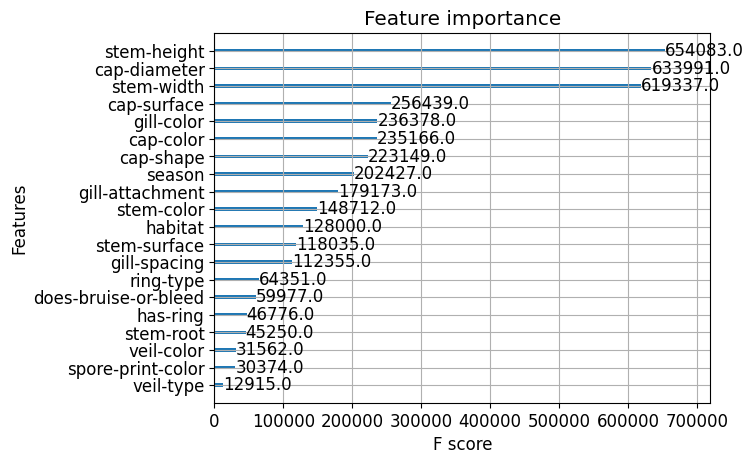

In [51]:
#plot_importance(xgb_model.fit(X_train, y_train))
plot_importance(xgb_model)

# LGBM

In [ ]:
%%time
"""

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_scores = []
    
    #for train_index, test_index in kfold.split(train_df):
    #print(f'train: {len(train_index)} samples, test: {len(test_index)} samples')

    for train_index, val_index in kfold.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        lgb_model_fold = lgb.LGBMClassifier(**params)  # Use params, not lgbm_params
        lgb_model_fold.fit(X_fold_train, y_fold_train)
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the AUC-ROC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
        
        # Calculate the average score across all folds
        return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)

"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [ ]:
#%%time
"""

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold
        lgb_model_fold = lgb.LGBMClassifier(**params)
        lgb_model_fold.fit(X_fold_train, y_fold_train)
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        
        # Calculate and store the MCC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
    
    # Calculate the average score across all folds
    return np.mean(fold_scores)

# Create and run the study
study = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)
"""


In [ ]:
#print('Best value:', study.best_value)
#print('Best trial:', study.best_trial.params)

In [ ]:
#%%time
"""
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
        'device_type': 'gpu'
    }
    
    K_FOLDS = 5  # Number of folds for cross-validation
    skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    fold_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Train the model on the current fold with early stopping
        lgb_model_fold = lgb.LGBMClassifier(**params)
        lgb_model_fold.fit(
            X_fold_train, y_fold_train,
            eval_set=[(X_fold_val, y_fold_val)],
            callbacks=[
                #LightGBMPruningCallback(trial, 'binary_logloss'),
                lgb.early_stopping(stopping_rounds=50, verbose=False)
            ]
        )
        
        y_pred_fold = lgb_model_fold.predict(X_fold_val)
        #y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
        
        # Calculate and store the MCC score for the current fold
        score = matthews_corrcoef(y_fold_val, y_pred_fold)
        fold_scores.append(score)
    
    # Calculate the average score across all folds
    return np.mean(fold_scores)

# Create and run the study with a progress bar
study = optuna.create_study(sampler=optuna.samplers.TPESampler(n_startup_trials=30, multivariate=True, seed=0), direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print('Best value:', study.best_value)
print('Best trial:', study.best_trial.params)
"""